## Import Data

In [ ]:
# Input data files are available in the "../input/" directory.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



In [ ]:
global_data = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
global_data.head()

In [ ]:
countries = ['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Egypt',
       'Iran', 'Israel', 'Bahrain', 'Kuwait', 'Austria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Latvia', 'Morocco', 'Saudi Arabia', 
       'Argentina', 'Chile', 'Jordan', 'Ukraine', 
       'Hungary', 'Poland',
       'Tunisia', 'Palestine', 'Bosnia and Herzegovina', 'Slovenia',
       'South Africa', 'Bhutan', 'Cameroon', 'Costa Rica', 'Peru',
       'Serbia', 'Slovakia', 'Togo', 'Vatican City',
       'Malta', 'Republic of Ireland', 'Bulgaria',
       'Maldives', 'Bangladesh', 'Moldova', 'Paraguay', 'Albania',
       'Cyprus', 'Brunei',  
       'Mongolia', 'Panama', 'Bolivia', 'Honduras', 'Congo (Kinshasa)',
       'Jamaica', 'Reunion', 'Turkey', 'Cuba', 'Guyana', 'Kazakhstan',
       'Kenya', 'Uruguay', 'Ghana',
       'Namibia', 'Venezuela','Kosovo',
       'Uzbekistan', 'Tanzania', 'Montenegro',
       'Kyrgyzstan', 'Mauritius', 'Nicaragua', 'Madagascar', 'Angola', 
       'Zimbabwe', 'Dominica', 'Syria', 'Laos',
       'West Bank and Gaza']

## Estimating recovered number

In [ ]:
# This is a function which plots (for in input country) the active, confirmed, and recovered cases, deaths, and the growth factor.
shifts = [1,8,12,16,20,23]

def plot_ratio(country):
    global table
    global table2   
    country_data = global_data[global_data['Country/Region']==country]
    provinces = country_data['Province/State'].unique()
    for province in provinces:
        province_data = country_data[country_data['Province/State']==province] 
        if len(provinces)==1:
             province_data = country_data 
        table = province_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
        table = table[table['Confirmed']>100]
        #table['ActiveCases'] = table['Confirmed'] - table['Recovered'] - table['Deaths']
        table.set_index('ObservationDate',inplace=True)
        table2 = []
        stds= []   
        for shift in shifts:
            table['Ratio'] = np.roll(np.array(table['Recovered']),-shift)/table['Confirmed']
            table['Ratio'] = table['Recovered']/table['Confirmed']

            if (len(table[table['Ratio'].notna()])>2) and not province in ['Mayotte','Martinique','Isle of Man','Victoria']:
                table2.append(table['Ratio'])
                stds.append(table['Ratio'][:-shift].std())

        
        if (len(stds)>0)and min(stds)>0.05:
            choice = stds.index(min(stds)) 
            choice = 0
            print('Country ',country,' Province ',province, ' Shifted by ',shifts[choice],' days')
            table2[choice][:-shifts[choice]].plot(title=country,rot=90,ylim=(0,3))
            temp = 1/(table['Confirmed'].max())*table['Confirmed']
            temp.plot()
            temp = 1/(table['Confirmed'].max())*table['Recovered']
            temp.plot()
           
            plt.show()

   
    return 


In [ ]:
plot_ratio('South Korea')

In [ ]:
for country in countries[3:]:
     print(country)
     plot_ratio(country)

In [ ]:
plot_ratio('Italy')

In [ ]:
plot_ratio('Spain')

In [ ]:
plot_ratio('France')

In [ ]:
plot_ratio('Israel')

In [ ]:
plot_ratio('Russia')

In [ ]:
plot_ratio('Japan',8)

In [ ]:
plot_ratio('Norway',8)

In [ ]:
plot_ratio('Sweden',8)

In [ ]:
plot_ratio('Finland',8)

In [ ]:
plot_ratio('Poland',8)

In [ ]:
plot_ratio('Russia',8)

## Rest of the World

In [ ]:
restofworld_data = global_data
for country in restofworld_data['Country/Region']:
    if country != 'Mainland China': 
        restofworld_data['Country/Region'] = restofworld_data['Country/Region'].replace(country, "RestOfWorld")

plot_country_active_confirmed_recovered('RestOfWorld')


## Smoothed vs Unsmoothed Growth Factor

The growth factor we see above for Rest Of World is smoothed, just for illustration, let's look at smoothed vs unsmoothed.

The orange plot is the unsmoothed growth factor data for all countries except for china, the blue is the smoothed data. Smoothed data is essentially a weighted average, you can see how we define it above.

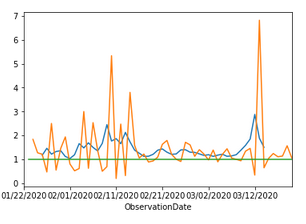

## Logistic Curve Fitting

We are going to use scipy.optimize.curve_fit to fit a logistic curve to the number of confirmed cases in Italy.

In [ ]:
from scipy.optimize import curve_fit


In [ ]:
# We want number of confirmed for each date for each country
#country_data = global_data[global_data['Country/Region']=='Mainland China']
global_data = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
country_data = global_data[global_data['Country/Region']=='Italy']

country_data = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
country_data = pd.pivot_table(country_data, values=['Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
country_data.tail()

In [ ]:
#country_data['GrowthFactor'] = growth_factor(country_data['Confirmed'])

# we will want x_data to be the number of days since first confirmed and the y_data to be the confirmed data. This will be the data we use to fit a logistic curve
x_data = range(len(country_data.index))
y_data = country_data['Confirmed']

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=50000)
estimated_k, estimated_x_0, ymax= popt


# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0
y_fitted = log_curve(x_data, k, x_0, ymax)
print(k, x_0, ymax)
#print(y_fitted)
y_data.tail()

### Notice that this predicts Italy hit the inflection point around day 53 (it is currently day 79 as of April 8th) and the number of confirmed cases will max out around 145,188 cases. The curve is certainly underestimating. Furthermore, for some countries, it is too early to use this method to get a reasonable estimate. We should also consider that the number of positive undiagnosed cases in each country is likely to be significant. Because most countries aren't testing enough, the mortality rate is likely inflated since the number of actual positive cases in each population is likely considerably higher than confirmed cases.

In [ ]:
# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_data, y_fitted, '--', label='fitted')
ax.plot(x_data, y_data, 'o', label='Confirmed Data')
